In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pypsa

In [2]:
def annuity(n,r): # annuity factor
    return r/(1.-1./(1.+r)**n)*(r>0)+1/n*(r<=0)

plants = pd.read_csv('data/plants/plants.csv', sep = ';', index_col = 0, comment = '#')

In [3]:
switch = {'year': 2030,
          'fuel': 'NH3',
          'battery': True,
          'wind': True,
          'solar': True,
          'increase_demand': False,
          'connection': False,
          'link_constraint': True,
          'location': 'Energy Island'}

In [4]:
# time index from year
t = pd.date_range('%d-01-01 00:00'%switch['year'], '%d-12-31 23:00'%switch['year'], freq = 'H')
# leap year
if (np.mod(switch['year'],100) != 0 and np.mod(switch['year'],4) == 0) or np.mod(switch['year'],400) == 0:
    t = t[:1416].union(t[1440:])

# weather data from refinement
cf = pd.DataFrame(index = t, columns = ['Wind','PV'])
cf['Wind'] = pd.read_csv('data/cf/wind_%s.csv'%plants['location'][switch['location']], index_col = 0).to_numpy()
cf['PV'] = pd.read_csv('data/cf/pv_%s.csv'%plants['location'][switch['location']], index_col = 0).to_numpy()

In [5]:
# efficiencies
eff = pd.Series(index = ['H2 Plant','NH3 Plant','H2 Engine','NH3 Engine','Battery','HVDC'], dtype = float)
eff['H2 Plant'] = 141.8/(50*3.6)
eff['NH3 Plant'] = 23/(9.9*3.6)
eff['H2 Engine'] = 0.55
eff['NH3 Engine'] = 0.38
eff['Battery'] = 0.9216
eff['HVDC'] = 0.97 # per 1000 km

# battery max charging hours
h_b = 6

# energy island fuel demand
load = 0.05*1.9e12/3.6/1000/8760 # MWh in every hour
if switch['increase_demand']: load *= 1.015**(switch['year']-2030)

# offwind: 21 large turbines, off-shore
# onwind: 20 Large wind turbines on land
# pv: large scale utility systems (NO axis-tracking)
# H2: AEC 100MW
# NH3: no electrolyzer, ASU ?
if switch['year'] == 2030:
    n = np.array([30,30,40,30,30,25]) # expected lifetime
    r = np.array([0.07]) # constant discount rate
    costdata = pd.DataFrame(np.array([[1.93e6,1.04e6,3.8e5,4.5e5,1.3e6,1.42e5*h_b+1.6e5], # €/MW
                                      [36053,12600,7250,9000,39000,540], # €/MW/year
                                      [2.7,1.35,0.01,0.01,0.02,0]]), # €/MWh
                            index = ['Investment','FOM','VOM'],
                            columns = ['Offshore Wind','Onshore Wind','Solar PV','H2 Plant','NH3 Plant','Battery'])
elif switch['year'] == 2040: 
    n = np.array([30,30,40,32,30,30]) # expected lifetime
    r = np.array([0.07]) # constant discount rate
    costdata = pd.DataFrame(np.array([[1.81e6,9.8e5,3.3e5,3e5,1.1e6,9.4e4*h_b+1e5], # €/MW
                                      [33169,11592,6625,6000,32000,540], # €/MW/year
                                      [2.5,1.24,0.01,0.01,0.02,0]]), # €/MWh
                            index = ['Investment','FOM','VOM'],
                            columns = ['Offshore Wind','Onshore Wind','Solar PV','H2 Plant','NH3 Plant','Battery'])
elif switch['year'] == 2050: 
    n = np.array([30,30,40,35,30,30]) # expected lifetime
    r = np.array([0.07]) # constant discount rate
    costdata = pd.DataFrame(np.array([[1.78e6,9.6e5,3e5,2.5e5,8e5,7.5e4*h_b+6e4], # €/MW
                                      [32448,11340,6250,5000,24000,540], # €/MW/year
                                      [2.4,1.22,0.01,0.01,0.02,0]]), # €/MWh
                            index = ['Investment','FOM','VOM'],
                            columns = ['Offshore Wind','Onshore Wind','Solar PV','H2 Plant','NH3 Plant','Battery'])
ccost = annuity(n,r)*costdata.loc['Investment']+costdata.loc['FOM'] # €/MW

In [6]:
dfr = 1.2 # detour factor

# onshore and offshore straight distance
if switch['location'] == 'Energy Island':
    distance = {'DK': (223,81.5), # Thorsminde-DK[Odense] km https://www.mapdevelopers.com/distance_from_to.php
                'DE': (773.26,81.5), # Thorsminde-DE
                'NO': (441.3,200), # Kristiansand-NO
                'NL': (816.55,81.5), # Thorsminde-NL
                'GB': (1321.97,327)} # Thorsminde-Rotterdam-Colchester

elif switch['location'] == 'DK Wind':
    distance = {'DK': (221.5,0), #  
                'DE': (771.14,0), #
                'NO': (466.5,182.32), # Hjørring-Larvik
                'NL': (814.19,0), # 
                'GB': (1322.88,245.5)} # Rotterdam-Colchester
    
elif switch['location'] == 'DK Solar':
    distance = {'DK': (104.15,0), #  
                'DE': (500,50), # Lolland-Fehmarn
                'NO': (649.37,182.32), # Hjørring-Larvik
                'NL': (540,50), # Lolland-Fehmarn
                'GB': (1069.51,295.5)} # Lolland-Fehmarn-Rotterdam-Colchester
    
elif switch['location'] == 'DE Wind':
    distance = {'DK': (495.15,0), #  
                'DE': (401.42,0), # 
                'NO': (931.39,182.32), # Hjørring-Larvik
                'NL': (296.54,0), # 
                'GB': (805.53,245.48)} # Rotterdam-Colchester

elif switch['location'] == 'DE Solar':
    distance = {'DK': (1161.24,0), #  
                'DE': (516.3,0), # 
                'NO': (1598.65,182.32), # Hørring-Larvik
                'NL': (841.71,0), # 
                'GB': (1295.03,245.5)} #
    
elif switch['location'] == 'NO Wind':
    distance = {'DK': (498.83,140.4), # Kristiansand-Hjørring 
                'DE': (1048.44,140.4), # 
                'NO': (485,0), # 
                'NL': (1088.87,140.4), # Kristiansand-Hjørring 
                'GB': (483.61,496.4)} # Aberdeen
    
elif switch['location'] == 'NO Solar':
    distance = {'DK': (306.31,182.32), #  
                'DE': (856.04,182.32), # 
                'NO': (251.19,0), # 
                'NL': (900,182.32), # 
                'GB': (1403.88,427.79)} # Hjørring-Rotterdam-Colchester 

elif switch['location'] == 'NL Wind':
    distance = {'DK': (674.93,0), #  
                'DE': (538.41,0), # 
                'NO': (1112.27,182.32), # Hjørring-Larvik
                'NL': (152.32,0), # 
                'GB': (605.46,245.48)} # Rotterdam-Colchester
    
elif switch['location'] == 'NL Solar':
    distance = {'DK': (750.9,0), #  
                'DE': (582,0), # 
                'NO': (1188.27,182.32), # Hjørring-Larvik
                'NL': (124.44,0), # 
                'GB': (531.81,245.48)} # Rotterdam-Colchester
    
elif switch['location'] == 'GB Wind':
    distance = {'DK': (931.79,245.48), # Colchester-Rotterdam
                'DE': (969.56,245.48), # Colchester-Rotterdam
                'NO': (1670.67,427.8), # Colchester-Rotterdam-Hjørring-Larvik
                'NL': (542.16,245.48), # Colchester-Rotterdam
                'GB': (87.28,0)} # 
    
elif switch['location'] == 'GB Solar':
    distance = {'DK': (1013.33,84.13), # Dunkirk
                'DE': (652.75,84.13), # Dunkirk
                'NO': (1450.2,266.45), # Dunkirk-Hjørring-Larvik
                'NL': (332.71,84.13), # Dunkirk
                'GB': (505.98,0)} # 

In [7]:
network = pypsa.Network()

network.set_snapshots(t)

network.add('Bus', 'Electricity')
network.add('Bus', switch['fuel'])

In [8]:
network.add('Link',
            switch['fuel']+' Plant',
            bus0 = 'Electricity',
            bus1 = switch['fuel'],
            p_nom_extendable = True,
            #p_nom_min = 5319.719576,
            efficiency = eff[switch['fuel']+' Plant'],
            capital_cost = ccost[switch['fuel']+' Plant'],
            marginal_cost = costdata.loc['VOM'][switch['fuel']+' Plant']*eff[switch['fuel']+' Plant'])

In [9]:
network.add('Load',
            'Fuel Demand',
            bus = switch['fuel'],
            p_set = load)

network.add('Store',
            'Free Tank',
            bus = switch['fuel'],
            e_nom_extendable = True,
            e_cyclic = True)

In [10]:
if switch['wind']:
    windname = 'Onshore Wind' if plants['onshore'][switch['location']] else 'Offshore Wind'
    network.add('Generator',
                windname,
                bus = 'Electricity',
                p_nom_extendable = True,
                p_nom_max = 10000,
                #p_nom_min = 5292.263671,
                capital_cost = ccost[windname],
                marginal_cost = costdata.loc['VOM'][windname],
                p_max_pu = cf['Wind'])

if switch['solar']:
    network.add('Generator',
                'Solar PV',
                bus = 'Electricity',
                p_nom_extendable = True,
                p_nom_max = 10000 if plants['onshore'][switch['location']] else 2000,
                #p_nom_min = 1139.036028,
                capital_cost = ccost['Solar PV'],
                marginal_cost = costdata.loc['VOM']['Solar PV'],
                p_max_pu = cf['PV'])

In [11]:
if switch['battery']:
    network.add('StorageUnit',
                'Battery',
                bus = 'Electricity',
                cyclic_state_of_charge = True,
                p_nom_extendable = True,
                p_nom_max = 800,
                #p_nom_min = 0,
                capital_cost = ccost['Battery'],
                marginal_cost = costdata.loc['VOM']['Battery'],
                efficiency_store = eff['Battery'],
                efficiency_dispatch = eff['Battery'],
                max_hours = h_b)

In [12]:
# Countries
if switch['connection']:
    mcost = pd.read_csv('data/market/price_%d.csv'%switch['year'], index_col = 0).set_index(t)
    load = pd.read_csv('data/market/load_%d.csv'%switch['year'], index_col = 0).set_index(t)
    for country in distance.keys():
        network.add('Bus', country)

        network.add('Generator',
                    'Elec_'+country,
                    bus = country,
                    p_nom_extendable = True,
                    marginal_cost = mcost[country])
        network.add('Load',
                    'Load_'+country, 
                    bus = country, 
                    p_set = load[country])

        cccost = (annuity(40,0.07)+0.02)*(400*distance[country][0]*dfr+2000*distance[country][1]*dfr+150000)
        cmcost = 0.01
        ceff = 1-(1-eff['HVDC'])*sum(distance[country])*dfr/1000
        if switch['link_constraint']:
            network.add('Link',
                        '%s to %s'%(switch['location'],country),
                        bus0 = 'Electricity',
                        bus1 = country,
                        p_nom_extendable = True,
                        p_nom_max = 1500,
                        efficiency = ceff,
                        capital_cost = cccost/2,
                        marginal_cost = cmcost)
            network.add('Link',
                        '%s to %s'%(country,switch['location']),
                        bus0 = country,
                        bus1 = 'Electricity',
                        p_nom_extendable = True,
                        p_nom_max = 1500,
                        efficiency = ceff,
                        capital_cost = cccost/2,
                        marginal_cost = cmcost)
        else:
            network.add('Bus', country+' Hub 1') # close to plant
            network.add('Bus', country+' Hub 2') # close to country

            network.add('Link',
                        '%s to %s Hub 1'%(switch['location'],country),
                        bus0 = 'Electricity',
                        bus1 = country+' Hub 1',
                        p_nom_extendable = True)
            network.add('Link',
                        '%s Hub 1 to %s'%(country,switch['location']),
                        bus0 = country+' Hub 1',
                        bus1 = 'Electricity',
                        p_nom_extendable = True,
                        efficiency = ceff,
                        marginal_cost = cmcost)
            network.add('Link',
                        '%s Hub 1 and %s Hub 2'%(country,country), 
                        bus0 = country+' Hub 1',
                        bus1 = country+' Hub 2',
                        p_nom_extendable = True,
                        p_nom_max = 1500,
                        p_min_pu = -1,
                        capital_cost = cccost) # marta
            network.add('Link',
                        '%s to %s Hub 2'%(country,country),
                        bus0 = country,
                        bus1 = country+' Hub 2',
                        p_nom_extendable = True)
            network.add('Link',
                        '%s Hub 2 to %s'%(country,country),
                        bus0 = country+' Hub 2',
                        bus1 = country,
                        p_nom_extendable = True,
                        efficiency = ceff,
                        marginal_cost = cmcost)
else:
    switch['link_constraint'] = False

In [13]:
if switch['link_constraint']:
    def add_cable_constrants(network):
        p = pypsa.linopt.get_var(network, 'Link', 'p_nom')
        pout = p.loc[['%s to %s'%(switch['location'],country) for country in distance.keys()]]
        pin = p.loc[['%s to %s'%(country,switch['location']) for country in distance.keys()]]
        lhs = pypsa.linopt.linexpr((1,pout.reset_index(drop = True)),(-1,pin.reset_index(drop = True)))
        pypsa.linopt.define_constraints(network, lhs, '=', 0, 'Cable')

    def extra_functionality(network, snapshots):
        add_cable_constrants(network)

In [14]:
network.lopf(network.snapshots,
             pyomo = False,
             extra_functionality = extra_functionality if switch['link_constraint'] else None,
             solver_name = 'gurobi')

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.57s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2022-10-03
Read LP format model from file /var/folders/3f/817ykyb972j227v95ln_qw480000gn/T/pypsa-problem-6_8hpkgd.lp
Reading time = 0.54 seconds
obj: 157680 rows, 70086 columns, 302162 nonzeros
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 157680 rows, 70086 columns and 302162 nonzeros
Model fingerprint: 0xcefe70a6
Coefficient statistics:
  Matrix range     [4e-06, 6e+00]
  Objective range  [1e-02, 2e+05]
  Bounds range     [8e+02, 1e+04]
  RHS range        [3e+03, 3e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 85089 rows and 15011 columns
Presolve time: 0.26s
Presolved: 72591 rows, 55075 columns, 193304 nonzeros

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 4
 AA' NZ     : 1.645e+05
 Factor NZ  : 9.143e+05 (roughly 60 MB of memor

INFO:pypsa.linopf:Optimization successful. Objective value: 2.50e+09


('ok', 'optimal')

In [15]:
((sum(network.buses_t.marginal_price['Electricity']*network.links_t.p0[switch['fuel']+' Plant'])
+network.links.capital_cost[switch['fuel']+' Plant']*network.links.p_nom_opt[switch['fuel']+' Plant']
+network.links.marginal_cost[switch['fuel']+' Plant']*network.links_t.p0[switch['fuel']+' Plant'].sum())
/sum(network.loads_t.p['Fuel Demand']))

95.16460842308918

In [16]:
(network.buses_t.marginal_price[switch['fuel']].max(),network.buses_t.marginal_price[switch['fuel']].min())

(95.16460867571735, 95.16460867571735)

In [17]:
network.objective

2498636267.8294983

In [18]:
network.objective/sum(network.loads_t.p['Fuel Demand'])

94.68516383352333

In [19]:
network.generators.p_nom_opt # in MW

Offshore Wind    7283.063876
Solar PV         2000.000000
Name: p_nom_opt, dtype: float64

In [20]:
network.storage_units.p_nom_opt

Battery    0.0
Name: p_nom_opt, dtype: float64

In [21]:
network.links.p_nom_opt # in MW

NH3 Plant    6442.969741
Name: p_nom_opt, dtype: float64

ZeroDivisionError: integer division or modulo by zero

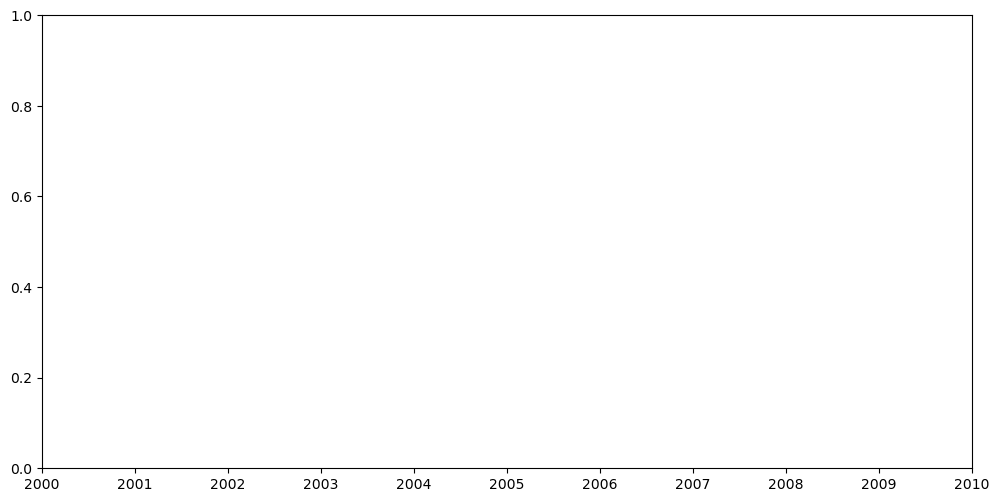

In [22]:
plt.figure(figsize=(12,6),dpi=100)
plt.plot(network.links_t.p0.filter(like=' to ')['%d-01-01 00:00'%switch['year']:'%d-01-08 00:00'%switch['year']])
plt.legend(labels=network.links_t.p0.filter(like=' to ').columns)
plt.show()